In [1]:
# import pandas packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from scipy.stats import mode
from collections import Counter

warnings.filterwarnings('ignore')

# Import parameters
import source.data_processing.clustering_params as params
from datetime import datetime

# Import the new clustering pipeline
from source.data_processing.clustering_pipeline import (
    ClusteringPipeline
)

# Import functions for data fetching
from source.data_processing.analysis_utils import (
    fetch_purchase_data,
)

# Visualization helper module previously referenced (clustering_visualization_utils) was removed.
# Use pipeline.generate_visualizations() after running clustering methods instead.


# Ensure notebook sees latest module changes
import importlib
import source.data_processing.clustering_utils as cu
import source.data_processing.clustering_pipeline as cp
import source.data_processing.analysis_utils as au
importlib.reload(cu)
importlib.reload(cp)
importlib.reload(au)

print(f"Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

📊 Performance Dependencies Status:
   ✓ db-dtypes: Enhanced BigQuery data type handling
   ✓ PyArrow: Fast data conversion (10-100x faster for large datasets)
✓ All performance dependencies are installed!

Analysis started at: 2025-11-17 13:35:48


## STEP 1: Running clustering pipeline

First we run all the steps to cluster the products based on their sales distribution.

One can opt for a standard pipeline. However, here the code is build to make two decisions:
    1) what is teh optimal number of clusters
    2) preferred clustering algorithm

In [2]:
# Create and configure the pipeline
pipeline = ClusteringPipeline(
    min_transactions=1,
    class3_description= None,
    product_description= None,
    max_clusters=10
)

print("🚀 Pipeline configured and ready!")

🚀 Clustering Pipeline initialized
   Min transactions: 1
   Class filter: None
   Product filter: None
🚀 Pipeline configured and ready!


🚀 Starting full clustering analysis pipeline...
   Timestamp: 2025-11-17 13:36:27
📥 Loading data...
Fetching clustering data from BigQuery...
🔧 Initializing BigQuery connector...
kramp-sharedmasterdata-prd
   Project ID: kramp-sharedmasterdata-prd
   Credentials path: C:\Users\madsh\AppData\Roaming\gcloud\application_default_credentials.json
   Initializing client...
   Checking credentials path...
   Credentials file found, creating client with credentials...
   Loading credentials file...
   Credentials file loaded, analyzing format...
   Detected user account credentials
   Refreshing expired credentials...
✓ Using user account credentials
   Creating BigQuery client...
   BigQuery client created successfully
✓ Connected to BigQuqery project: kramp-sharedmasterdata-prd
🔍 Executing query...
   Query preview: SELECT * FROM `kramp-sharedmasterdata-prd.MadsH.purchase_data`
   Submitting query to BigQuery...
✓ Using user account credentials
   Creating BigQuery client...
   BigQuery clie

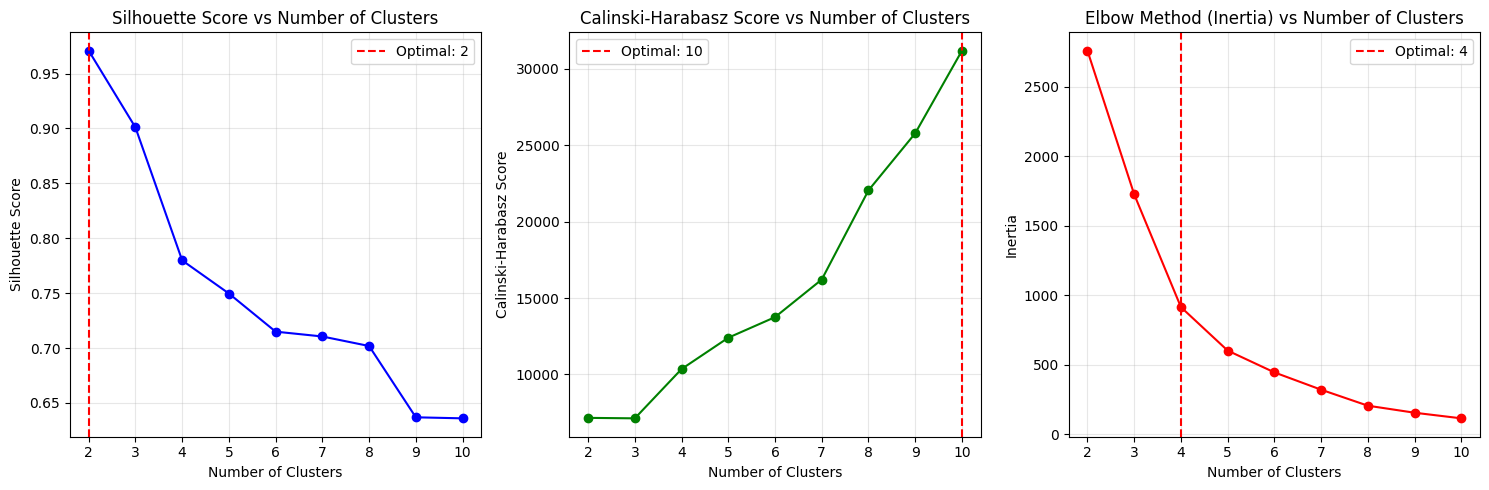

✅ Cluster optimization completed
   Optimal by Silhouette: 2
   Optimal by Calinski-Harabasz: 10
   Optimal by Elbow: 4


{'optimal_silhouette': 2,
 'optimal_calinski': 10,
 'optimal_elbow': 4,
 'silhouette_scores': [0.9707711057301276,
  0.9008964625981856,
  0.7798046413756898,
  0.7496616939071481,
  0.7149460500150621,
  0.7105370400571959,
  0.7018646969325936,
  0.6369387275292325,
  0.6359980779838887],
 'calinski_scores': [7159.820637592309,
  7128.709201717674,
  10353.979689251153,
  12404.499820230818,
  13751.44145202803,
  16211.372465627637,
  22048.586712788958,
  25782.876609173676,
  31187.825062673455],
 'inertias': [2757.7942924279,
  1724.7359853301014,
  914.0361972593369,
  601.5922368531218,
  444.78151611627055,
  320.3433804026075,
  205.31754146233797,
  154.7514689510636,
  114.38797928148568],
 'cluster_range': [2, 3, 4, 5, 6, 7, 8, 9, 10]}

In [3]:
print(f"🚀 Starting full clustering analysis pipeline...")
print(f"   Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Step 1: Load data
pipeline.load_data()

# Step 2: Prepare features
pipeline.prepare_features()

# Step 3: Optimize clusters
pipeline.optimize_clusters()


🎯 Step 4: Running kmeans clustering...
⚡ Using MiniBatchKMeans for clustering
📊 Analyzing Kmeans cluster characteristics...
✅ Cluster analysis completed for 5 clusters
📊 Analyzing Kmeans cluster characteristics...
✅ Cluster analysis completed for 5 clusters
✅ Kmeans clustering completed with 5 clusters

📊 Step 5: Comparing clustering methods...
✅ Method comparison completed
   Methods compared: ['kmeans']

📈 Step 6: Generating visualizations...
   📊 Plotting optimization metrics...
✅ Kmeans clustering completed with 5 clusters

📊 Step 5: Comparing clustering methods...
✅ Method comparison completed
   Methods compared: ['kmeans']

📈 Step 6: Generating visualizations...
   📊 Plotting optimization metrics...


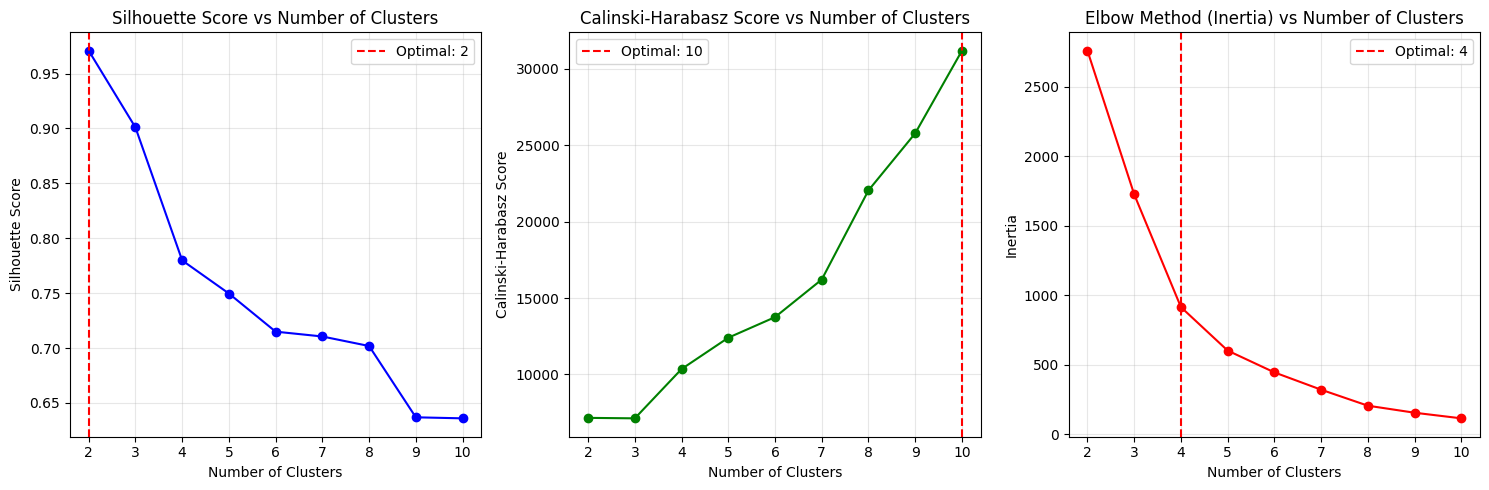

   📊 Generating kmeans visualizations...


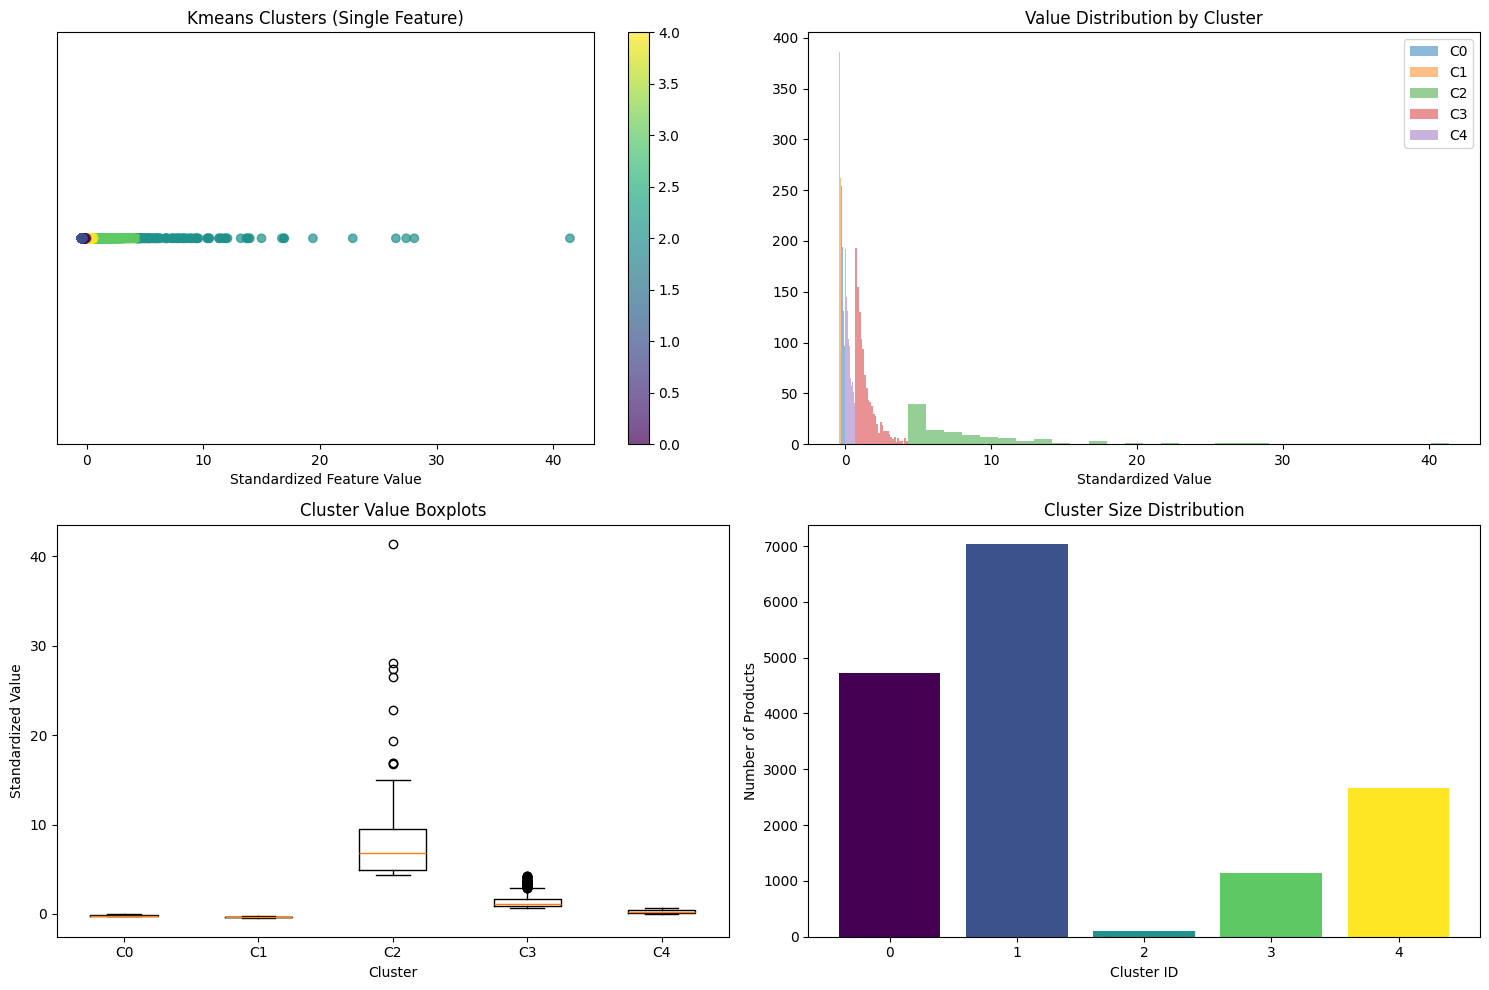

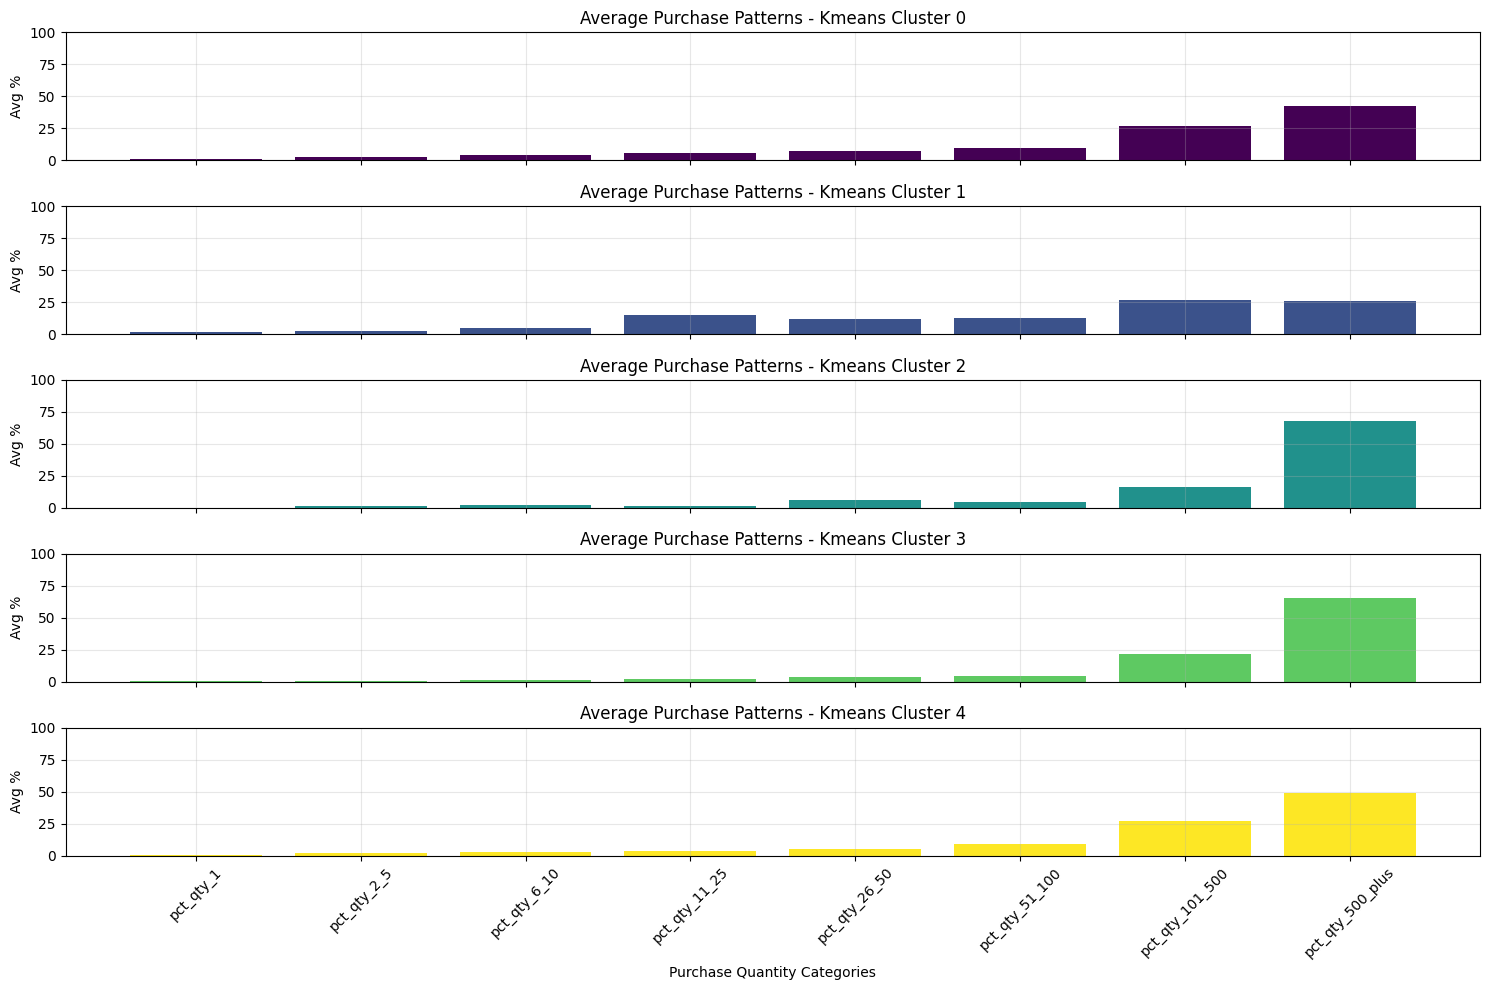

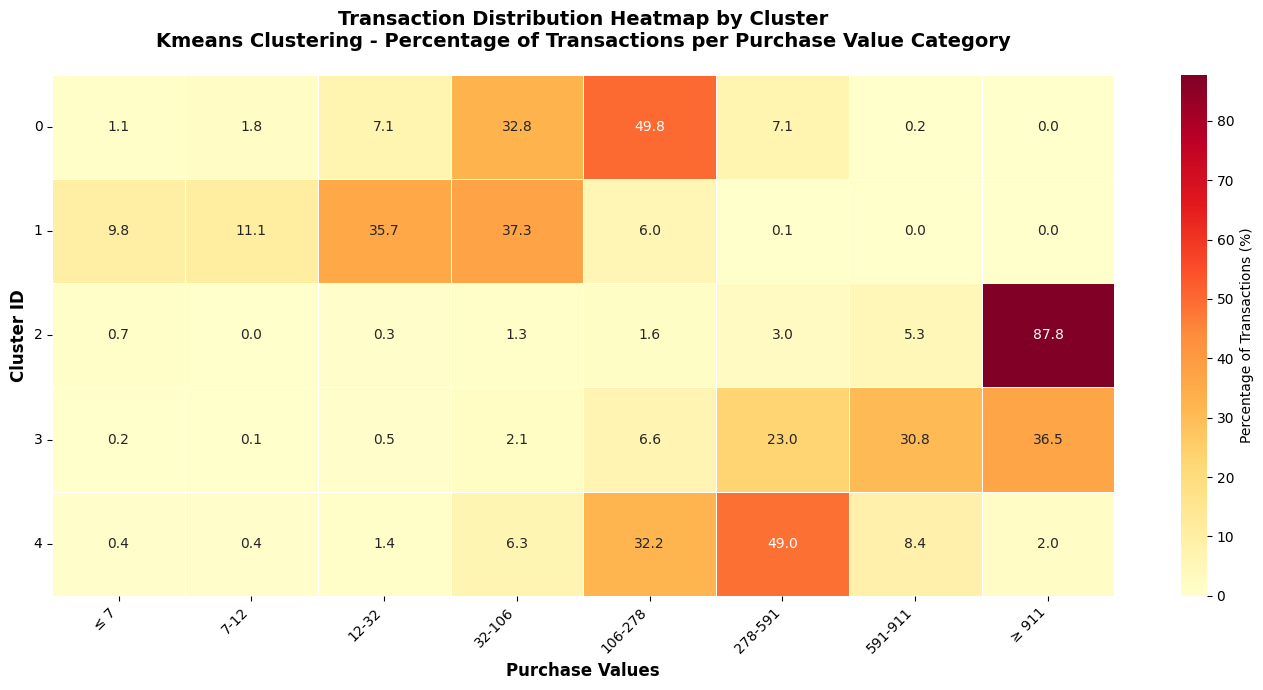


🔍 Heatmap Insights:
   Total clusters analyzed: 5
   Purchase values categories: 8
   Cluster 0: highest share in '106-278' (49.8%)
   Cluster 1: highest share in '32-106' (37.3%)
   Cluster 2: highest share in '≥ 911' (87.8%)
   Cluster 3: highest share in '≥ 911' (36.5%)
   Cluster 4: highest share in '278-591' (49.0%)
✅ Visualizations generated
   Methods visualized: ['optimization_metrics', 'kmeans']


In [4]:
NUMBER_CLUSTERS = 5
# Step 4: Run clustering methods
if params.INCLUDE_KMEANS:
    pipeline.run_kmeans_clustering(NUMBER_CLUSTERS)

# if params.INCLUDE_HIERARCHICAL:
#     pipeline.run_hierarchical_clustering(NUMBER_CLUSTERS)

# Step 5: Compare methods
pipeline.compare_clustering_methods()

# Step 6: Generate visualizations
if params.SHOW_VISUALIZATIONS:
    pipeline.generate_visualizations()

In [5]:
CHOSEN_METHOD = ['kmeans'] # ['kmeans', 'hierarchical', 'dbscan']
# Step 7: Export results
if params.EXPORT_RESULTS:
    pipeline.export_results(methods=CHOSEN_METHOD)



💾 Step 7: Exporting results...
   💾 Exporting kmeans results...
💾 Saving clustering results to clustering_results_20251117_133919.xlsx and cluster_summary_20251117_133919.xlsx...
✅ Results exported
   Files created: 2
✅ Results exported
   Files created: 2


## STEP 2: Get all mapped products

In [6]:
# Map products to clusters
mapped_products = pipeline.clustering_results['kmeans']['df_clustered'][['ProductNumber', 'kmeans_cluster']]

In [8]:
# Load the list of products
list_products = mapped_products['ProductNumber'].tolist()
list_products = list(set(list_products))

# Create a SQL-formatted string with list of products
products_list = "'" + "', '".join(list_products) + "'"

print(f"📊 Prepared product list for {len(list_products)} products with duplicates")

📊 Prepared product list for 15659 products with duplicates


## STEP 3: Cluster Analysis

Now we'll run comprehensive analysis per cluster to understand the business characteristics of each product group.

Available columns: ['ProductNumber', 'total_spend', 'avg_purchase_amount_eur', 'std_purchase_amount_eur', 'total_transactions', 'purchase_quantity', 'purchase_amount_eur', 'year_authorization', 'crm_main_group_vendor', 'ProductDescription', 'class3', 'purchase_count', 'avg_unit_price', 'pct_qty_1', 'pct_qty_2_5', 'pct_qty_6_10', 'pct_qty_11_25', 'pct_qty_26_50', 'pct_qty_51_100', 'pct_qty_101_500', 'pct_qty_500_plus', 'pct_purchase_amount_eur_le_7', 'pct_purchase_amount_eur_7-12', 'pct_purchase_amount_eur_12-32', 'pct_purchase_amount_eur_32-106', 'pct_purchase_amount_eur_106-278', 'pct_purchase_amount_eur_278-591', 'pct_purchase_amount_eur_591-911', 'pct_purchase_amount_eur_gt_911']

Top class3 by total_spend:


,class3,total_spend_eur,display
0,5405 | Bolts & Nuts,4.153329e+07,"41,533,293 EUR"
1,"5475 | Springs, Rivets & Hose Clips",1.025237e+07,"10,252,371 EUR"
2,5495 | Chain & Wire Rope & Acc.,9.413912e+06,"9,413,912 EUR"
3,5425 | Washers & Spacers,6.856809e+06,"6,856,809 EUR"
4,5435 | Wall Fixings,5.128388e+06,"5,128,388 EUR"
5,5450 | Cable Ties,4.771985e+06,"4,771,985 EUR"
6,5485 | Iron Mongery,3.775049e+06,"3,775,049 EUR"
7,5415 | Threaded Rods,2.580286e+06,"2,580,286 EUR"
8,5465 | Rings & Discs & Keys,1.883302e+06,"1,883,302 EUR"
9,5445 | Pins & Bushes,1.786678e+06,"1,786,678 EUR"


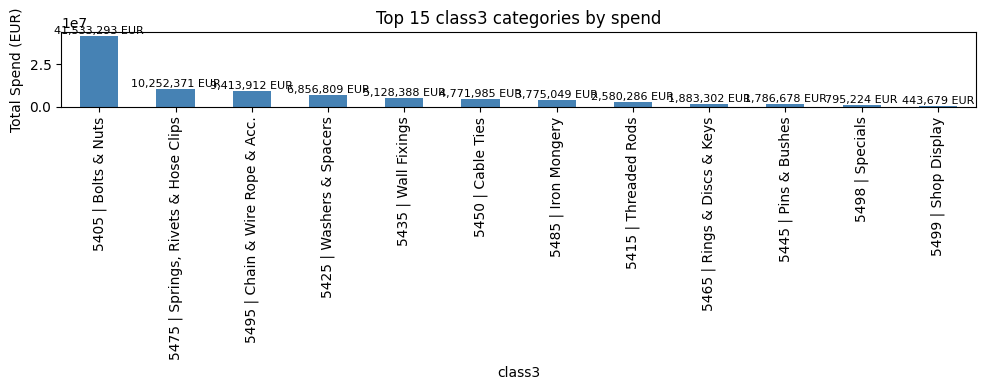


Top Group Vendors by total_spend:


,crm_main_group_vendor,total_spend_eur,display
0,G9000_22249 | STAFA GROUP,9.973690e+06,"9,973,690 EUR"
1,G9000_20819 | SCHAFER + PETERS GROUP,7.599124e+06,"7,599,124 EUR"
2,G9000_10750 | KOBOUT GROUP,7.325017e+06,"7,325,017 EUR"
3,G9000_26484 | CHIN WELL GROUP,7.297054e+06,"7,297,054 EUR"
4,G9000_22090 | EUROBOLT GROUP,6.476301e+06,"6,476,301 EUR"
5,G9000_10783 | KRAMP V GROUP,5.650524e+06,"5,650,524 EUR"
6,G9000_26627 | KAINUO GROUP,4.724387e+06,"4,724,387 EUR"
7,G9000_27926 | JET SUCCESS GROUP,4.698365e+06,"4,698,365 EUR"
8,G9000_11336 | FISCHER GROUP,3.443259e+06,"3,443,259 EUR"
9,G9000_22180 | LINKWELL GROUP,3.249733e+06,"3,249,733 EUR"


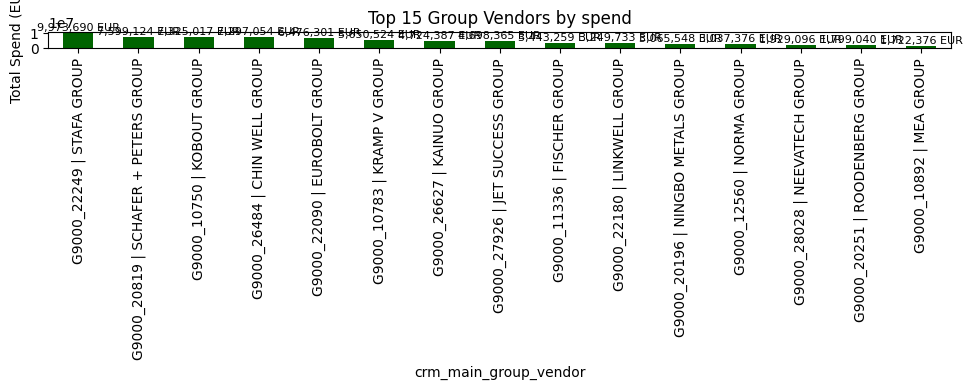


Running ABC segmentation (80/95 thresholds) ...
⚠️ ABC segmentation failed: 'ClusteringPipeline' object has no attribute 'run_abc_segmentation'
ABC segmentation unavailable (spend column missing).


In [15]:
# Spend distribution summaries (auto-derive missing spend columns)
df_base = pipeline.data.copy()
print("Available columns:", df_base.columns.tolist())

# Helper for formatting EUR values
def format_eur(v):
    try:
        return f"{int(round(v)):,} EUR"
    except Exception:
        return "NA"

# 1. Spend by class3
if 'class3' in df_base.columns and 'total_spend' in df_base.columns:
    class3_spend = (df_base.groupby('class3')['total_spend']
                    .sum()
                    .sort_values(ascending=False))
    top15_class3 = class3_spend.head(15)
    print("\nTop class3 by total_spend:")
    display(pd.DataFrame({
        'class3': top15_class3.index,
        'total_spend_eur': top15_class3.values,
        'display': [format_eur(v) for v in top15_class3.values]
    }))
    plt.figure(figsize=(10,4))
    ax = top15_class3.plot(kind='bar', color='steelblue')
    plt.ylabel('Total Spend (EUR)')
    plt.title('Top 15 class3 categories by spend')
    # Annotate bars
    for p in ax.patches:
        val = p.get_height()
        ax.annotate(format_eur(val),
                    (p.get_x() + p.get_width()/2, val),
                    ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()
else:
    print("class3 or total_spend column still missing; cannot compute class3 spend.")

# 2. Spend by Group Vendor
if 'crm_main_group_vendor' in df_base.columns and 'total_spend' in df_base.columns:
    vendor_spend = (df_base.groupby('crm_main_group_vendor')['total_spend']
                    .sum()
                    .sort_values(ascending=False))
    top15_vendor = vendor_spend.head(15)
    print("\nTop Group Vendors by total_spend:")
    display(pd.DataFrame({
        'crm_main_group_vendor': top15_vendor.index,
        'total_spend_eur': top15_vendor.values,
        'display': [format_eur(v) for v in top15_vendor.values]
    }))
    plt.figure(figsize=(10,4))
    ax = top15_vendor.plot(kind='bar', color='darkgreen')
    plt.ylabel('Total Spend (EUR)')
    plt.title('Top 15 Group Vendors by spend')
    for p in ax.patches:
        val = p.get_height()
        ax.annotate(format_eur(val),
                    (p.get_x() + p.get_width()/2, val),
                    ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()
else:
    print("crm_main_group_vendor or total_spend column still missing; cannot compute vendor spend.")

# 3. ABC segmentation (run if not present)
if 'abc_segmentation' not in pipeline.analysis_results:
    try:
        print("\nRunning ABC segmentation (80/95 thresholds) ...")
        abc_results = pipeline.run_abc_segmentation(spend_col='total_spend', thresholds=(0.80,0.95), include_models=False)
    except Exception as e:
        print(f"⚠️ ABC segmentation failed: {e}")
else:
    abc_results = pipeline.analysis_results['abc_segmentation']
if 'abc_segmentation' in pipeline.analysis_results:
    abc_df = abc_results['abc_df']
    tier_counts = abc_df['abc_tier'].value_counts().sort_index()
    print("\nABC Tier Counts:")
    print(tier_counts)
    # Show tier share summary
    display(abc_results['abc_summary'])
else:
    print("ABC segmentation unavailable (spend column missing).")

In [ ]:
# Cluster distribution and spend summaries (enhanced: derive total_turnover if missing)
# Source data comes from pipeline.data (aggregated/raw) and cluster assignments.
clustered_df = pipeline.clustering_results['kmeans']['df_clustered'].copy()
print("Cluster distribution:")
cluster_counts = clustered_df['kmeans_cluster'].value_counts().sort_index()
print(cluster_counts)

# Ensure a spend column
if 'total_turnover' not in clustered_df.columns:
    # Attempt derivation from available columns
    if 'avg_purchase_amount_eur' in clustered_df.columns and 'total_transactions' in clustered_df.columns:
        clustered_df['total_turnover'] = clustered_df['avg_purchase_amount_eur'] * clustered_df['total_transactions']
        print("\nDerived total_turnover from avg_purchase_amount_eur * total_transactions.")
    elif 'purchase_amount_eur' in clustered_df.columns and 'total_transactions' in clustered_df.columns:
        clustered_df['total_turnover'] = clustered_df['purchase_amount_eur'] * clustered_df['total_transactions']
        print("\nDerived total_turnover from purchase_amount_eur (avg) * total_transactions.")
    else:
        print("\nUnable to derive total_turnover (required columns missing).")

# Cluster total spend
if 'total_turnover' in clustered_df.columns:
    cluster_spend = clustered_df.groupby('kmeans_cluster')['total_turnover'].sum().sort_index()
    print("\nCluster total_turnover (EUR):")
    print(cluster_spend)
    plt.figure(figsize=(8,4))
    cluster_spend.plot(kind='bar', color='slateblue')
    plt.ylabel('Total Turnover (EUR)')
    plt.title('Cluster Spend (Total Turnover)')
    plt.tight_layout()
    plt.show()
else:
    print("Column 'total_turnover' not found and could not be derived; skipping spend plot.")

# Optional per-year spend (representative year)
if 'year_authorization' in clustered_df.columns and 'total_turnover' in clustered_df.columns:
    year_spend = clustered_df.groupby(['kmeans_cluster','year_authorization'])['total_turnover'].sum().unstack(fill_value=0)
    if year_spend.shape[1] > 1:
        print("\nApproximate spend per cluster per year_authorization (representative):")
        print(year_spend)
    else:
        print("\nPer-year breakdown skipped (only one year or insufficient variation).")
else:
    print("year_authorization or total_turnover missing; cannot produce year-level summary.")

Cluster distribution:
kmeans_cluster
0    4723
1    7029
2     106
3    1144
4    2657
Name: count, dtype: int64
Column 'total_turnover' not found; cannot compute cluster spend.

Per-year breakdown skipped (only one year or insufficient data).


## STEP 4: Data Preparation and Feature Engineering

Before running the comprehensive analysis, we need to prepare additional features and metrics.

In [ ]:
# Data preparation and feature engineering (fixed: removed pipeline.purchase_data)
print(f"🚀 Data preparation and feature engineering completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

base_df = pipeline.data.copy()
print("Columns available:", base_df.columns.tolist())

# 1. Extract representative year
if 'year_authorization' in base_df.columns:
    base_df['Year'] = pd.to_datetime(base_df['year_authorization'], errors='coerce').dt.year
else:
    base_df['Year'] = np.nan

# 2. Countries per class3 (only if countryOfOrigin present)
if 'countryOfOrigin' in base_df.columns and 'class3' in base_df.columns:
    country_counts = base_df.groupby('class3')['countryOfOrigin'].nunique().reset_index().rename(columns={'countryOfOrigin':'NumCountries'})
    print("\nCountries per class3 (top 10):")
    display(country_counts.head(10))
else:
    print("\nSkipping country counts (columns missing).")

# 3. Product-level metrics (mode & 90th quantile of purchase_amount_eur) using aggregated purchase_amount_eur
if 'purchase_amount_eur' in base_df.columns and 'ProductNumber' in base_df.columns:
    product_metrics = base_df.groupby('ProductNumber')['purchase_amount_eur'].agg(
        Mode=lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan,
        Quantile90=lambda x: x.quantile(0.9)
    ).reset_index().rename(columns={'Mode':'PurchaseAmountMode','Quantile90':'PurchaseAmount90thQuantile'})
    print("\nSample product metrics:")
    display(product_metrics.head())
else:
    print("\nSkipping product metrics (purchase_amount_eur or ProductNumber missing).")

# 4. Assemble simplified metrics dataframe
metrics_cols = [c for c in ['ProductNumber','purchase_amount_eur','purchase_quantity','total_turnover','avg_unit_price','year_authorization','Year','class3','crm_main_group_vendor'] if c in base_df.columns]
product_metrics_df = base_df[metrics_cols].copy()
print("\nSample of base metrics:")
display(product_metrics_df.head())

🚀 Data preparation and feature engineering completed at: 2025-11-17 13:39:50


AttributeError: 'ClusteringPipeline' object has no attribute 'purchase_data'

## STEP 5: Comprehensive Cluster Analysis

In [ ]:
run_comprehensive_cluster_analysis(clustered_orders,
                                      product_metrics,
                                      show_plots=True)

## STEP 6: Save clustering results to BigQuery

In [ ]:
# Save clustering results to BigQuery
pipeline.save_results_to_bq(method='kmeans')